You need first to install pymanopt with jax wrapper and also jax to run the code. Using pip simply type the lines

pip install pymanopt[jax]

pip install jax

In [ ]:
pip install jax
pip install 'pymanopt[jax]'

In [1]:
# Minimal modules to run example

import jax.numpy as jnp
import jax.numpy.linalg as jln
import jax.random as jrand
from jax.scipy.linalg import sqrtm as sqrtm
import pymanopt
from pymanopt.manifolds import SymmetricPositiveDefinite as SPD
from pymanopt import Problem
import matplotlib.pyplot as plt

In [2]:
# Fix an input set in R^d (we take random vectors on the unit sphere) and compute its gram matrix (K or K^(1) in our terminology)

def random_vectors(n, d, new = True, unit = True):
    # Generate n random points in d dimensions
    key = jrand.key(42)
    if new:
        key, subkey = jrand.split(key)
        points = jrand.normal(subkey, shape = (n, d))
    else:
        points = jrand.normal(key, shape = (n, d))
    
    # Normalize the points to lie on the unit sphere
    if unit:
        norms = jln.norm(points, axis = 1, keepdims = True)
        vectors = points / norms
    else:
        vectors = points
    return vectors

def random_positive_vectors(n, d, new = True, unit = True):
    # Generate n random points in d dimensions
    key = jrand.key(42)
    if new:
        key, subkey = jrand.split(key)
        points = jnp.abs(jrand.normal(subkey, shape = (n, d)))
    else:
        points = jnp.abs(jrand.normal(key, shape = (n, d)))
    
    # Normalize the points to lie on the unit sphere
    if unit:
        norms = jln.norm(points, axis=1, keepdims=True)
        vectors = points / norms
    else:
        vectors = points
    return vectors

In [3]:
# computation Legendre-Fenchel transform, linear activation function
# We use directly R = sqrt(K) as parameters

def Phi_conjugate_pymanopt(R, R_in, n):
    #define the manifold
    manifold = SPD(n)

    #define the cost function
    R_inv = jln.inv(R_in)
    K = R @ R.T
    @pymanopt.function.jax(manifold)
    def cost(I_minus_M):
        M = R_inv @ (jnp.eye(n) - I_minus_M) @  R_inv.T
        return -jnp.trace(M @ K) - 1/2*jnp.log( jln.det(I_minus_M) )

    #define the problem
    problem = Problem(manifold, cost)
    # solve the problem
    optimizer = pymanopt.optimizers.TrustRegions()
    result = optimizer.run(problem)
    return -result.cost, result.point

# theoretical expression for the Fenchel-Legendre transform
def Phi_conjugate_linear(R, R_in, n):
    R_inv = jln.inv(R_in)
    K = R @ R.T
    return jnp.trace(R_inv @ K @ R_inv) - (n / 2) - (1 / 2) * jnp.log(jln.det(2 * R_inv @ K @ R_inv))

In [4]:
# compare with theoretical expression
n = 2
R = jnp.eye(n)
R_in=jnp.array([[2, 1], [1, 4]])

Phi_conj_pymanopt, lam_pymanopt = Phi_conjugate_pymanopt(R, R_in, n)
Phi_conj_lin = Phi_conjugate_linear(R, R_in, n)

print(Phi_conj_pymanopt)
print(Phi_conj_lin)

Optimizing...
                                            f: -2.042726e-01   |grad|: 4.591979e-01
acc TR+   k:     1     num_inner:     0     f: -2.985253e-01   |grad|: 4.183866e-01   exceeded trust region
acc TR+   k:     2     num_inner:     0     f: -4.606317e-01   |grad|: 3.480940e-01   exceeded trust region
acc TR+   k:     3     num_inner:     0     f: -6.716747e-01   |grad|: 1.541784e-01   exceeded trust region
acc       k:     4     num_inner:     1     f: -7.006384e-01   |grad|: 3.396878e-02   reached target residual-kappa (linear)
acc       k:     5     num_inner:     1     f: -7.017414e-01   |grad|: 1.080423e-03   reached target residual-theta (superlinear)
acc       k:     6     num_inner:     1     f: -7.017426e-01   |grad|: 1.164798e-06   reached target residual-theta (superlinear)
acc       k:     7     num_inner:     1     f: -7.017426e-01   |grad|: 1.356594e-12   model increased
Terminated - min grad norm reached after 7 iterations, 1.03 seconds.

0.7017425603321028
0.

In [4]:
# Single hidden layer architecture with linear activation, rate function for the kernel
# We use the analytic expression for the Legendre transform and minimize over R_hidden (the square root of the hidden layer covariance)

def I_K3(R_out, R_in, n):
    #define the manifold
    manifold = SPD(n)

    #define the cost function
    @pymanopt.function.jax(manifold)
    def cost(R_hidden):
        return Phi_conjugate_linear(R_out, R_hidden, n) + Phi_conjugate_linear(R_hidden, R_in, n)

    #define the problem
    problem = Problem(manifold, cost)

    # solve the problem
    optimizer = pymanopt.optimizers.TrustRegions(verbosity = 0)
    result = optimizer.run(problem)
    return result.cost, result.point


# for comparison, one-dimensional case
def I_K3_theoretical(R_out, R_in):
    return 2 * jnp.trace(R_out) / jnp.trace(R_in) - 1 - jnp.log(2 * jnp.trace(R_out / R_in))

In [6]:
# check for consistency with the one-dimensional case 
n = 1
R_in = jnp.eye(n)
R_out = 2 * jnp.eye(n)

I_K_pymanopt, _ = I_K3(R_out, R_in, n)
I_K_lin = I_K3_theoretical(R_out,R_in)

print('value of I_K computed with pymanopt:', I_K_pymanopt)
print('theoretical value of I_K:', I_K_lin)

Optimizing...
                                            f: +1.700979e+00   |grad|: 1.680246e+00
acc       k:     1     num_inner:     0     f: +1.613728e+00   |grad|: 2.689011e-02   maximum inner iterations
acc       k:     2     num_inner:     0     f: +1.613706e+00   |grad|: 1.139424e-07   maximum inner iterations
Terminated - min grad norm reached after 2 iterations, 0.92 seconds.

value of I_K computed with pymanopt: 1.6137056388801096
theoretical value of I_K: 1.6137056388801094


In [ ]:
# Example of computation in the higher dimensional case
n = 2
R_out = jnp.eye(n)
#anp.array( [[1, 0.2], [0.2, 1]])
R_in = jnp.eye(n) 
#anp.array( [[2, -0.1], [-0.1, 3]])

I_K_pymanopt, k_opt_pymanopt = I_K3(R_out, R_in, n)

print('value of I_K computed with pymanopt:', I_K_pymanopt)
print('optimizer:', k_opt_pymanopt)

Optimizing...
                                            f: +3.070427e+00   |grad|: 7.476396e+00
acc TR+   k:     1     num_inner:     0     f: +1.776478e+00   |grad|: 4.702488e+00   exceeded trust region
acc       k:     2     num_inner:     1     f: +6.610310e-01   |grad|: 8.748918e-01   reached target residual-kappa (linear)
acc       k:     3     num_inner:     1     f: +6.137183e-01   |grad|: 1.421701e-02   reached target residual-kappa (linear)
acc       k:     4     num_inner:     1     f: +6.137056e-01   |grad|: 6.734983e-08   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 4 iterations, 0.79 seconds.

value of I_K computed with pymanopt: 0.6137056388801098
optimizer: [[1.00000001e+00 2.41061235e-09]
 [2.41061235e-09 1.00000000e+00]]


In [ ]:
# Single hidden layer architecture linear activation, rate function for the network output
# We use the I_K and minimize with quadratic penalty

def I_F_shallow(output_vectors, R_in):
    n = R_in.shape[0]
    
    #define the manifold
    manifold = SPD(n)

    #define the cost function
    @pymanopt.function.jax(manifold)
    def cost(R_out):
        return Phi_conjugate_linear(R_out, R_in, n) + (1 / 2) * jln.norm(jln.inv(R_out) @ output_vectors.T)**2

    #define the problem
    problem = Problem(manifold, cost)

    # solve the problem
    optimizer = pymanopt.optimizers.TrustRegions(verbosity = 0)
    result = optimizer.run(problem)
    return result.cost, result.point

# compare with I_F theoretical when n = 1
def I_F_shallow_linear(y, R_in):
    # Shallow case: explicit formula
    value = (1 + jnp.sqrt(1 + 8 * jln.norm(y)**2 / R_in**2)) / 4 - (1 / 2) - jnp.log((1 + jnp.sqrt(1 + 8 * jln.norm(y)**2 / R_in**2)) / 2) / 2 + 2 * jln.norm(y)**2 / ((R_in**2) * (1 + jnp.sqrt(1 + 8 * jln.norm(y)**2 / R_in**2)))
    min_point = (1 + jnp.sqrt(1 + 8 * jln.norm(y)**2 / R_in**2)) / R_in**2
    return value, min_point

In [6]:
# We use the I_K3 and minimize with quadratic penalty

# both input vectors and output vectors should be given as an array (each row corresponds to a vector)
def I_F3(output_vectors, input_vectors, max_it_gd=6, max_it_loop=4):    
    n = input_vectors.shape[0]
    # Compute the Gram matrix for the input_vectors
    K_in = input_vectors @ input_vectors.T
    # take the square root and use it as k_in_sqrt (takes only the real part)
    R_in = sqrtm(K_in).real
    # notice that we cannot differentiate sqrtm, it is not implemented in JAX!

    #define the manifolds
    manifold_k_hidden = SPD(n)
    manifold_k_out = SPD(n)

    #define the costs
    def cost_k_hidden(R_out, R_hidden):
        return Phi_conj_lin(R_out, R_hidden, n) + Phi_conjugate_linear(R_hidden, R_in, n)
    
    def cost_k_out(R_out, R_hidden):
        return cost_k_hidden(R_out, R_hidden) +  (1 / 2) * jln.norm(jln.inv(R_out) @ output_vectors.T)**2
    
    #initialize points randomly
    R_hidden = manifold_k_hidden.random_point()
    R_out = manifold_k_out.random_point()

    # Save the estimated I_F along the iterations
    I_F_history = []
    for _ in range(max_it_loop):
        # Define wrapper functions to handle optimization
        @pymanopt.function.jax(manifold_k_hidden)
        def cost_k_hidden_wrapper(R_hidden):
           return cost_k_hidden(R_out, R_hidden)

        # Optimize with respect to R_hidden
        problem_k_hidden = Problem(manifold_k_hidden, cost_k_hidden_wrapper)
        optimizer_k_hidden = pymanopt.optimizers.SteepestDescent(max_iterations = max_it_gd, verbosity = 0)
        R_hidden = optimizer_k_hidden.run(problem_k_hidden).point

        # Define wrapper functions to handle optimization
        @pymanopt.function.jax(manifold_k_out)
        def cost_k_out_wrapper(R_out):
           return cost_k_out(R_out, R_hidden)

        # Optimize with respect to R_out
        problem_k_out = Problem(manifold_k_out, cost_k_out_wrapper)
        optimizer_k_out = pymanopt.optimizers.SteepestDescent(max_iterations = max_it_gd, verbosity = 0)
        R_out = optimizer_k_out.run(problem_k_out).point
        I_F_history.append( cost_k_out(R_out, R_hidden) )
        #print('iteration:', i, 'estimated I_F:', cost_k_out(R_out, R_hidden))
    return I_F_history, R_out, R_hidden

In [15]:
# check for consistency with the one-dimensional case 
d = 1
n = 1

# Generate random input vectors (where evaluating the network) and output vaules (where evaluating the rate function)
input_vectors = random_positive_vectors(n, d, unit = False)
output_vectors = random_vectors(1, n, unit = False)
print(input_vectors)
print(output_vectors)

# compute I_F on input_vectors and output_vectors
I_F_pymanopt, R_out_opt_pymanopt = I_F_shallow(output_vectors, input_vectors)
#I_F_history, R_out, _ = I_F3(output_vectors, input_vectors)
I_F_lin, k_opt_lin = I_F_shallow_linear(output_vectors, input_vectors)

print('value of I_F computed with pymanopt: ', I_F_pymanopt, '; minimized at: ', R_out_opt_pymanopt)
print('theoretical value of I_F: ', I_F_lin, '; minimized at: ', k_opt_lin)

[[0.64989201]]
[[0.64989201]]
value of I_F computed with pymanopt:  0.6534264097200275 ; minimized at:  [[0.64989201]]
theoretical value of I_F:  [[0.65342641]] ; minimized at:  [[9.47060217]]


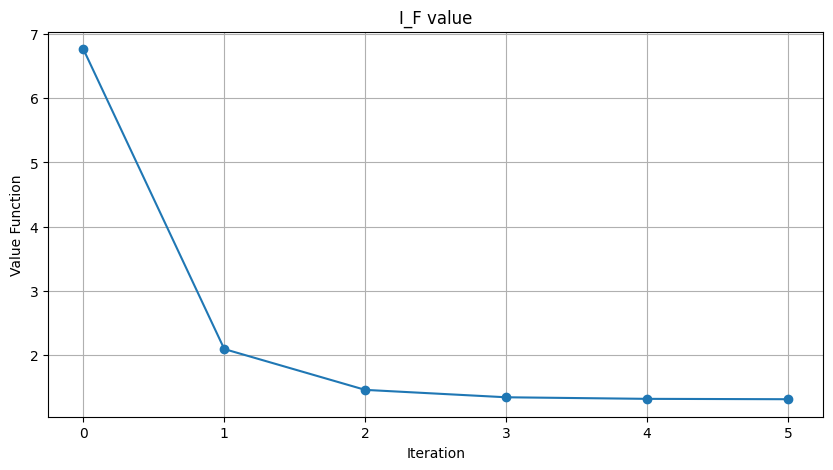

In [ ]:
# set dimension larger than n to avoid singular matrices
d=9
n=6

# Generate random input vectors (where evaluating the network) and output vaules (where evaluating the rate function)
input_vectors = random_vectors(n, d)
output_vectors = random_vectors(1, n)

# compute I_F on input_vectors and output_vectors
I_F_history, R_out, R_hidden = I_F_shallow(output_vectors, input_vectors, max_it_gd = 20, max_it_loop = 6)
#print(I_F_history[-1], '\n', R_out, '\n', R_hidden)

# we plot the iterated estimates of I_F
I_F_history = jnp.array([val.item() for val in I_F_history])

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(I_F_history, marker = 'o')
plt.title('I_F value')
plt.xlabel('Iteration')
plt.ylabel('Value Function')
plt.grid()
plt.show()

### 3D Graph of the Legendre-Fenchel Transform

This plot visualizes the **Legendre-Fenchel transform** $I_K$ as a function of parameters $x$ and $y$ in a parametrized 2×2 matrix:

$$
R(x, y) =
\begin{bmatrix}
1 & x \\
0 & y
\end{bmatrix}
\quad \Rightarrow \quad K = R R^\top
$$

We fix a reference matrix $R_{\text{in}}$, and for each grid point $(x, y)$, we compute the rate function:

$$
I_K = \sup_{M \in \text{SPD}} \left\{ \mathrm{tr}(M K) + \log \det(I - M) \right\}
$$

This is solved using **manifold optimization** over the space of **symmetric positive definite (SPD)** matrices via **Pymanopt with JAX** automatic differentiation.



#### Axes:
- **x-axis**: Off-diagonal component of $R$
- **y-axis**: Scale component of the lower row of $R$
- **z-axis**: Value of the Legendre-Fenchel transform $I_K$



This surface shows how the rate function varies as the structure of the covariance matrix $K$ changes. It shows how certain configurations of $R$ affect the large deviation behavior of the output of a Gaussian neural network with linear activation.

Peaks in the surface indicate configurations with higher rate,less probable behavior, while valleys indicate more typical configurations under the Gaussian measure.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

def plot_legendre_fenchel_surface(R_in, n=2, grid_size=200):
    x_vals = np.linspace(-1.0, 5.0, grid_size)
    y_vals = np.linspace(0.01, 2.0, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(grid_size):
        for j in range(grid_size):
            x = X[i, j]
            y = Y[i, j]
            R = jnp.array([[1.0, x],
                           [0.0, y]])
            try:
                Z[i, j] = Phi_conjugate_linear(R, R_in, n)
            except:
                Z[i, j] = np.nan  # fill failed points with NaN

    fig = plt.figure(figsize = (14, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
    ax1.plot_surface(X, Y, Z, cmap = 'viridis', edgecolor = 'none')
    ax1.set_xlabel('x (off-diagonal of R)')
    ax1.set_ylabel('y (scale of R)')
    ax1.set_title(f'3D Surface of FL Transform vs (x, y) for sqrt(K)=\n{R_in}')
    # Contour plot
    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(X, Y, Z, levels = 30, cmap = 'viridis')
    fig.colorbar(contour, ax = ax2)
    ax2.set_title(f"Contour Plot")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.tight_layout()
    plt.savefig("FLlindim2.pdf", format = "pdf")
    plt.show()

def plot_I_K_surface_jax(R_in, n = 2, grid_size = 20):
    x_vals = np.linspace(-1.0, 5.0, grid_size)
    y_vals = np.linspace(0.1, 2.0, grid_size)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = np.zeros_like(X)

    for i in range(grid_size):
        for j in range(grid_size):
            x = X[i, j]
            y = Y[i, j]
            R = jnp.array([[1.0, x],
                           [0.0, y]])
            try:
                val, _ = I_K3(R, R_in, n)
                Z[i, j] = val
            except:
                Z[i, j] = np.nan  # fill failed points with NaN

    fig = plt.figure(figsize = (14, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
    ax1.plot_surface(X, Y, Z, cmap = 'viridis', edgecolor = 'none')
    ax1.set_xlabel('x (off-diagonal of R)')
    ax1.set_ylabel('y (scale of R)')
    ax1.set_title(f'3D Surface of I_K^(3) vs (x, y) for sqrt(K^(1))=\n{R_in}')
    # Contour plot
    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(X, Y, Z, levels = 30, cmap = 'viridis')
    fig.colorbar(contour, ax = ax2)
    ax2.set_title(f"Contour Plot")
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    plt.tight_layout()
    plt.savefig("I_K3lindim2.pdf", format = "pdf")
    plt.show()

def plot_I_F_shallow_surface_jax(R_in, n = 2, grid_size = 20):
    # Create two fixed output directions
    v1 = random_vectors(1, n).reshape(-1)
    v2 = random_vectors(1, n).reshape(-1)

    # Define grid over (a, b)
    grid_range = np.linspace(-5, 5, grid_size)
    A, B = np.meshgrid(grid_range, grid_range)
    Z = np.zeros_like(A)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a, b = A[i, j], B[i, j]
            output_vector = (a * v1 + b * v2).reshape(1, -1)
            try:
                I_F_history, _ = I_F_shallow(output_vector, R_in)
                Z[i, j] = float(I_F_history)
            except:
                Z[i, j] = np.nan  # in case of failure

    fig = plt.figure(figsize = (14, 6))
    ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
    ax1.plot_surface(A, B, Z, cmap = 'viridis', edgecolor = 'none')
    ax1.set_xlabel('a (scaling of y_1)')
    ax1.set_ylabel('b (scaling of y_2)')
    ax1.set_title(f'3D Surface of I_F^(2) vs (a, b) for sqrt(K^(1))=\n{R_in}')
    # Contour plot
    ax2 = fig.add_subplot(1, 2, 2)
    contour = ax2.contourf(A, B, Z, levels = 30, cmap = 'viridis')
    fig.colorbar(contour, ax = ax2)
    ax2.set_title(f"Contour Plot")
    ax2.set_xlabel('a')
    ax2.set_ylabel('b')
    plt.tight_layout()
    plt.savefig("I_F2lindim2.pdf", format = "pdf")
    plt.show()

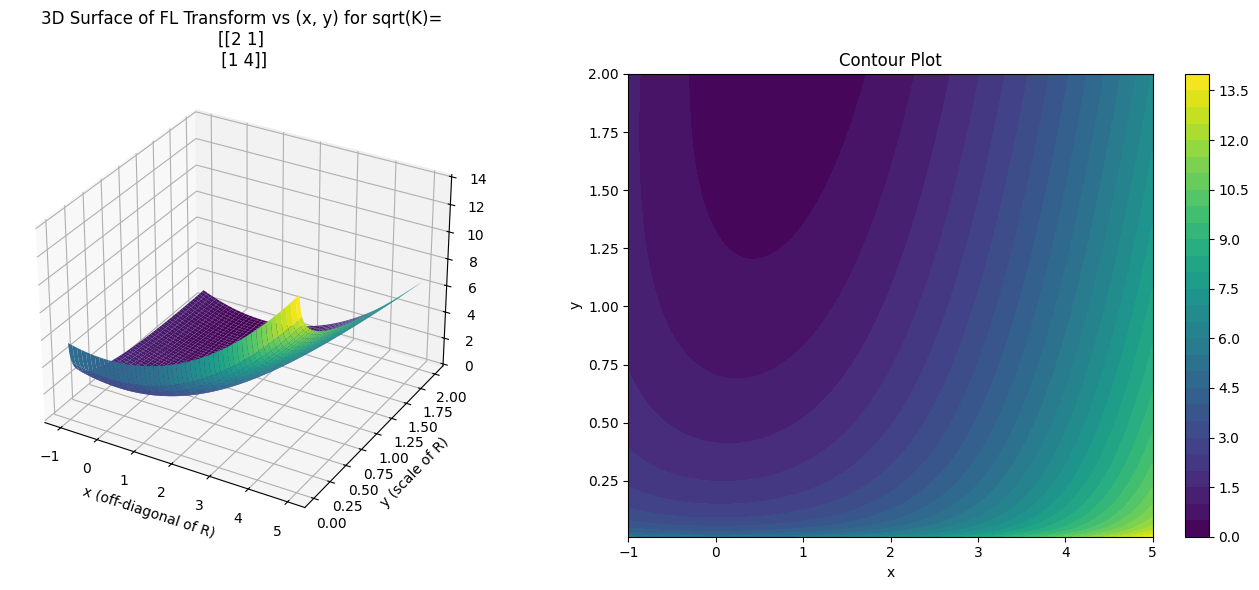

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymanopt\optimizers\trust_regions.py:579: RuntimeWarning: invalid value encountered in sqrt
  norm_r = np.sqrt(r_r)


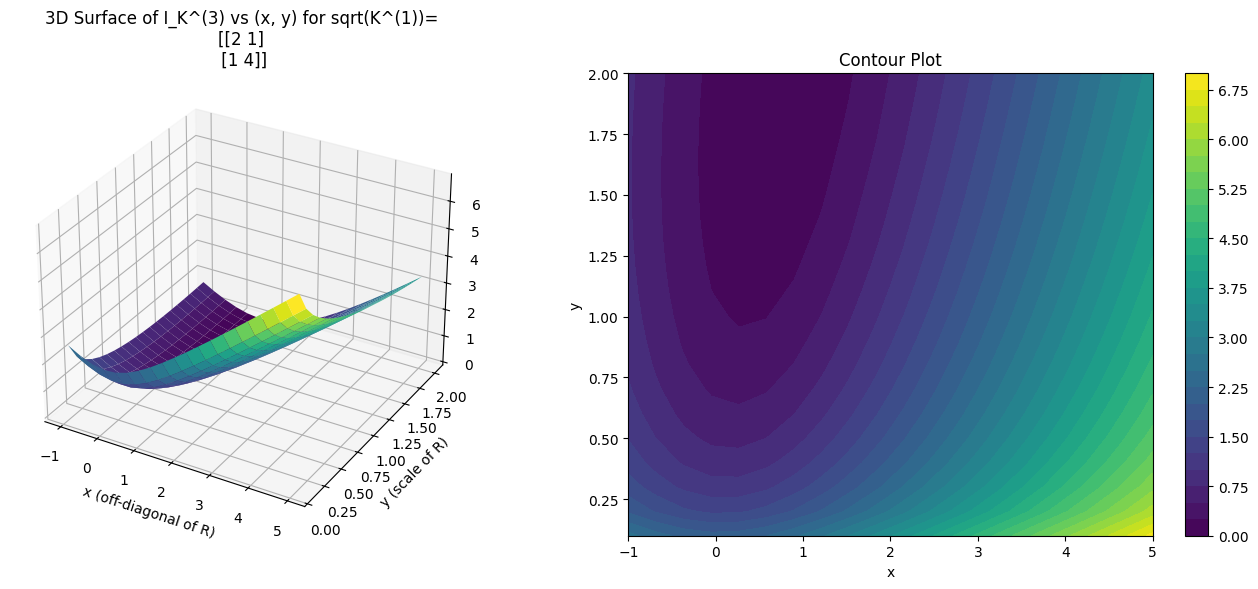

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymanopt\optimizers\trust_regions.py:579: RuntimeWarning: invalid value encountered in sqrt
  norm_r = np.sqrt(r_r)


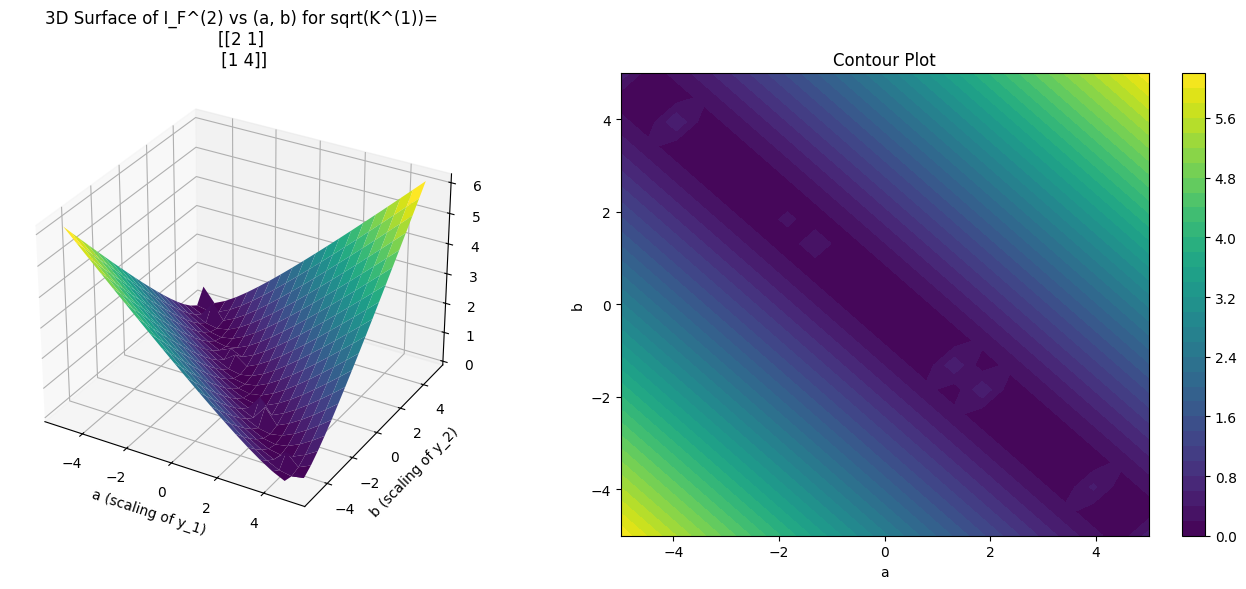

In [8]:
R_in = jnp.array([[2, 1], [1, 4]])  # or any positive definite matrix
#R_in = jnp.eye(2)
plot_legendre_fenchel_surface(R_in)
plot_I_K_surface_jax(R_in)
plot_I_F_shallow_surface_jax(R_in)

Optimizing...
                                            f: +1.286119e+01   |grad|: 1.801379e+01
acc TR+   k:     1     num_inner:     0     f: +5.970221e+00   |grad|: 7.807621e+00   exceeded trust region
acc       k:     2     num_inner:     1     f: +3.337148e+00   |grad|: 1.060268e+00   reached target residual-kappa (linear)
acc       k:     3     num_inner:     1     f: +3.277146e+00   |grad|: 8.258339e-02   reached target residual-kappa (linear)
acc       k:     4     num_inner:     2     f: +3.276783e+00   |grad|: 1.222678e-03   reached target residual-theta (superlinear)
acc       k:     5     num_inner:     4     f: +3.276783e+00   |grad|: 3.400866e-07   reached target residual-theta (superlinear)
Terminated - min grad norm reached after 5 iterations, 0.16 seconds.



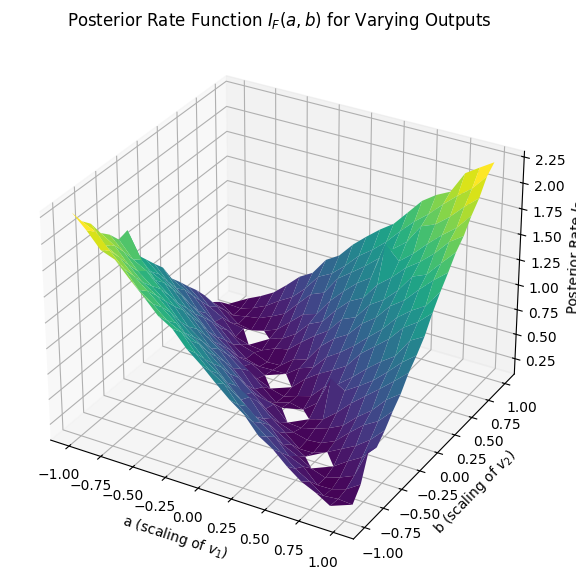

In [ ]:
# Fix input and setup
d = 10
n = 6
input_vectors = random_vectors(n, d)

# Create two fixed output directions
v1 = random_vectors(1, n).reshape(-1)
v2 = random_vectors(1, n).reshape(-1)

# Define grid over (a, b)
grid_range = np.linspace(-5, 5, 20)
A, B = np.meshgrid(grid_range, grid_range)
Z = np.zeros_like(A)

# Compute posterior rate I_F over the grid
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        a, b = A[i, j], B[i, j]
        output_vector = (a * v1 + b * v2).reshape(1, -1)
        try:
            I_F_history, _, _ = I_F_shallow(output_vector, input_vectors, max_it_gd = 8, max_it_loop = 3)
            Z[i, j] = float(I_F_history[-1])
        except:
            Z[i, j] = np.nan  # in case of failure

# Plot the surface
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, Z, cmap='viridis', edgecolor='none')
ax.set_title("Rate Function I_F(a, b) for Varying Outputs")
ax.set_xlabel("a (scaling of y_1)")
ax.set_ylabel("b (scaling of y_2)")
plt.show()

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymanopt\optimizers\trust_regions.py:579: RuntimeWarning: invalid value encountered in sqrt
  norm_r = np.sqrt(r_r)


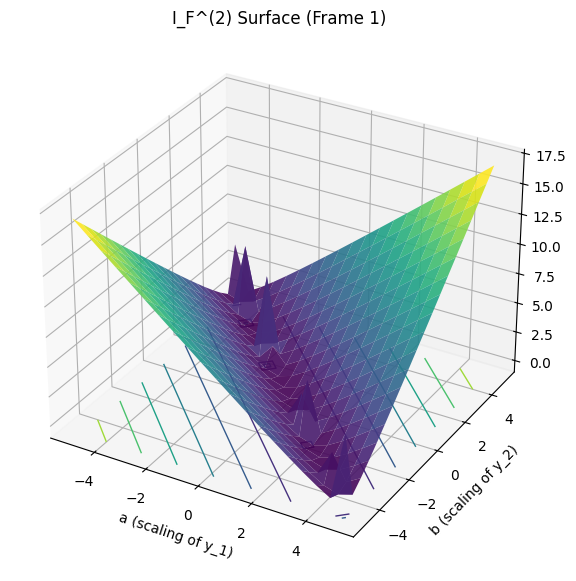

In [30]:
from matplotlib import animation
from IPython.display import HTML

# Animation: how I_F changes as input vectors vary

d = 10
n = 2
num_frames = 10

grid_range = np.linspace(-5.0, 5.0, 20)
A, B = np.meshgrid(grid_range, grid_range)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

def generate_surface(frame_idx):
    ax.clear()
    
    # New random input vectors and corresponding R_in
    input_vectors = random_vectors(n, d)
    K_in = input_vectors @ input_vectors.T
    R_in = sqrtm(K_in).real
    
    v1 = random_vectors(1, n).reshape(-1)
    v2 = random_vectors(1, n).reshape(-1)

    Z = np.zeros_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            a, b = A[i, j], B[i, j]
            output_vector = (a * v1 + b * v2).reshape(1, -1)
            try:
                I_F_history, _ = I_F_shallow(output_vector, R_in)
                Z[i, j] = float(I_F_history)
            except:
                Z[i, j] = np.nan

    # Plot posterior surface
    ax.plot_surface(A, B, Z, cmap = 'viridis', edgecolor = 'none', alpha = 0.9)
    
    # Add contour projection
    ax.contour(A, B, Z, zdir = 'z', offset = np.nanmin(Z) - 1, cmap = 'viridis', linewidths = 1.0)
    
    # Labels
    ax.set_title(f"I_F^(2) Surface (Frame {frame_idx+1})")
    ax.set_xlabel("a (scaling of y_1)")
    ax.set_ylabel("b (scaling of y_2)")
    ax.set_zlim(np.nanmin(Z) - 1, np.nanmax(Z) + 1)

# Create animation
anim = animation.FuncAnimation(fig, generate_surface, frames = num_frames, interval = 1000)

# Display animation
HTML(anim.to_jshtml())
